In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import random
from sklearn.metrics import silhouette_score
import seaborn as sns

In [19]:
from const import action_map

In [20]:
action_map

{2: 'subject_nose_poke_side',
 3: 'subject_sniff_tail',
 4: 'subject_sniff_nose',
 5: 'stimulus_sniff_subject_tail',
 6: 'mutual_sniff_of_tail',
 7: 'random_walk',
 8: 'both_are_moving_to_sniff',
 9: 'subject_head_scratch'}

In [2]:
def find_optimal_clusters(data, max_clusters=10):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    wcss = []  # Within-cluster sum of squares
    clusters = []
    for num_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        data = kmeans.fit_transform(scaled_data)
        wcss.append(kmeans.inertia_)
        clusters.append(data)
    
    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.show()

    diff = np.diff(wcss)
    diff_ratio = diff[1:] / diff[:-1]
    optimal_clusters = np.argmin(diff_ratio) + 2  # Add 2 to account for 0-based indexing


    return wcss, clusters, optimal_clusters

def perform_clustering_and_plot(df, k_clusters=4, plot_flag=False):
    # Assuming your DataFrame has only feature columns
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)
    
    # Perform k-NN clustering
    kmeans = KMeans(n_clusters=k_clusters)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Perform UMAP for dimensionality reduction
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(scaled_features)
#     embedding = []
    if plot_flag:
        # Create a scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=50)
        plt.title('UMAP Clustering')
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.colorbar()
        plt.show()
    return cluster_labels, embedding

In [7]:
import os
import os.path as osp
os.getcwd()

'D:\\Project- Electro\\Predict_Social_Behavior\\src\\correct_simaba_files'

In [30]:
# df_path = 'cropped_Rat1 probe 4-day2-free_2019-05-13-114301-0000.csv'
df_path = 'cropped_Rat10-probe13-day1-free_2018-07-15-103307-0000.csv'
folder_path = 'samples'
df_full_path = osp.join(folder_path,df_path)
df = pd.read_csv(df_full_path)

In [9]:
distance_vars = [
    'Nose_to_nose_distance',
#     'M1_Nose_to_M2_lat_left',
#     'M1_Nose_to_M2_lat_right',
#     'M2_Nose_to_M1_lat_left',
#     'M2_Nose_to_M1_lat_right',
    'M1_Nose_to_M2_tail_base',
    'M2_Nose_to_M1_tail_base'
]

special_joints = [
    'Nose_1_x',
    'Nose_1_y',
    
    'Tail_base_1_x',
    'Tail_base_1_y',
    
    
    'Nose_2_x',
    'Nose_2_y',
    
    'Tail_base_2_x',
    'Tail_base_2_y',    
]




In [10]:
from scipy.signal import gaussian, convolve

def generate_gaussian_kernel(frame_rate, window_length_ms, std_dev_factor=2.0):
    # Convert window length from milliseconds to frames
    window_length_frames = int(frame_rate * (window_length_ms / 1000))
    
    # Calculate the standard deviation based on the std_dev_factor
    std_dev = window_length_frames / (2 * std_dev_factor)
    
    # Generate the Gaussian kernel
    kernel = gaussian(window_length_frames, std_dev)
    
    # Normalize the kernel to have a sum of 1
    kernel /= np.sum(kernel)
    
    return kernel


def calculate_derivative_and_add_column(dataframe, column_name, keep_smoothed=False):
    # Step 1: Extract the values of the column
    column_values = dataframe[column_name].values
    
    # Step 2: Create an empty numpy array with the same length
    derivative_array = np.empty_like(column_values)
    
    # Step 3: Populate the array with the derivative of the column values
    kernel = generate_gaussian_kernel(frame_rate=29, window_length_ms=200)
    smoothed_values = convolve(column_values, kernel, mode='same')    
    
    derivative_array[1:] = np.diff(smoothed_values)
    derivative_array[0] = 0  # Since there's no previous value for the first element
    
    # Step 4: Add a new column with the derivative values
    new_column_name = f"{column_name}_derivative"
    dataframe[new_column_name] = derivative_array
    
    if keep_smoothed:
        dataframe[column_name] = smoothed_values
    
    return new_column_name

In [ ]:
# scale pose data using distance between two joints 



In [11]:
distance_delta = [calculate_derivative_and_add_column(df, c, True) for c in distance_vars]   
distance_delta_delta = [calculate_derivative_and_add_column(df, c, True) for c in distance_delta]  

special_joints_delta = [calculate_derivative_and_add_column(df, c, True) for c in special_joints]   
# special_joints_delta_delta = [calculate_derivative_and_add_column(df, c, True) for c in special_joints_delta]   

In [12]:
additional_distances_dict = {
    'Nose_to_nose_distance':50,
    'M1_Nose_to_M2_tail_base':50,
    'M2_Nose_to_M1_tail_base':50,
    
    'Nose_to_nose_distance_derivative':0,
    'M1_Nose_to_M2_tail_base_derivative':0,
    'M2_Nose_to_M1_tail_base_derivative':0,
    
}
additional_distances_logical = []

for a, th in additional_distances_dict.items():
    df[a+'_logical'] = (df[a]<th)*1
    additional_distances_logical.append(a+'_logical')

In [13]:
all_joints = [a for a in df.columns if any(substring in a for substring in ['_x', '_y'])]

columns_for_clustering = special_joints + special_joints_delta + distance_vars + distance_delta + distance_delta_delta #+ additional_distances_logical
columns_for_display = distance_vars + distance_delta

# cluster_data = df[columns_for_clustering]
cluster_data = df[columns_for_clustering]
df_pose = df[all_joints+columns_for_display]

In [14]:
columns_for_clustering

['Nose_1_x',
 'Nose_1_y',
 'Tail_base_1_x',
 'Tail_base_1_y',
 'Nose_2_x',
 'Nose_2_y',
 'Tail_base_2_x',
 'Tail_base_2_y',
 'Nose_1_x_derivative',
 'Nose_1_y_derivative',
 'Tail_base_1_x_derivative',
 'Tail_base_1_y_derivative',
 'Nose_2_x_derivative',
 'Nose_2_y_derivative',
 'Tail_base_2_x_derivative',
 'Tail_base_2_y_derivative',
 'Nose_to_nose_distance',
 'M1_Nose_to_M2_tail_base',
 'M2_Nose_to_M1_tail_base',
 'Nose_to_nose_distance_derivative',
 'M1_Nose_to_M2_tail_base_derivative',
 'M2_Nose_to_M1_tail_base_derivative',
 'Nose_to_nose_distance_derivative_derivative',
 'M1_Nose_to_M2_tail_base_derivative_derivative',
 'M2_Nose_to_M1_tail_base_derivative_derivative']

In [15]:
print(len(columns_for_clustering))
print(len(set(columns_for_clustering)))

25
25


In [16]:
# cluster_labels, embedding = perform_clustering_and_plot(cluster_data, k_clusters=4, plot_flag=True)

In [17]:
from copy import deepcopy


def standard_scaler(data):
    nsignals = len(data)
    for i in range(nsignals):
    #normalize to avoid spikes/plateaus during dtw due to differences in amplitudes
        normed_sig = (data[i]- np.mean(data[i]))/np.std(data[i])
        data[i] = normed_sig
    return data

def tkeo_operator(data, k = 1):

    npnts = len(data[0])
    nsignals = len(data)
    filt_data = deepcopy(data)
    for i in range(nsignals):
        for n in range(k, npnts-k):
            filt_data[i][n] = data[i][n]**2-data[i][n-1]*data[i][n+1]
    return filt_data


def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return np.sqrt(LB_sum)

def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])


def k_means_clust(data,num_clust,num_iter,w=5):
    centroid_inds = random.sample(range(len(data)),num_clust)
    centroids=data[centroid_inds,:]
    counter=0
    patience_val = 0
    patience = 3
    silhouette_scores = []
    best_silhouette_scores = -1
    labels = np.full((len(data), 1), -1)
    for n in range(num_iter):
        counter+=1
        print(f'Iteration: {counter}')
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
            labels[ind] = closest_clust
        
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
        
      
        silhouette_avg = silhouette_score(data, labels.ravel())
        silhouette_scores.append(silhouette_avg)
        

        # Optional: Break the loop if the change in silhouette score is small
        if silhouette_avg > best_silhouette_scores:
            print(f'new best silhouette_scores: {best_silhouette_scores:.4f} -> {silhouette_avg:.4f}')
            best_silhouette_scores = silhouette_avg
            patience_val = 0
            best_centroids = centroids
            best_labels = labels
            best_assignments = assignments
            
        elif silhouette_avg - best_silhouette_scores < 1e-5:
            if patience_val > patience:
                break
            else:
                print(f'No imporvments silhouette_scores: {best_silhouette_scores:.3f} -> {silhouette_avg:.3f}, {patience_val} of {patience}')
                patience_val += 1
        
                    
    return best_centroids, best_assignments, best_labels


In [28]:
data = cluster_data.values


#standard scaler
filt_data = standard_scaler(data)

#tkeo operator 
filt_data = tkeo_operator(data)

#standard scaler
filt_data = standard_scaler(filt_data)


centroids, assignments, labels = k_means_clust(filt_data,num_clust=6, num_iter=20,w=250)

Iteration: 1
new best silhouette_scores: -1.0000 -> 0.1080
Iteration: 2
new best silhouette_scores: 0.1080 -> 0.1904
Iteration: 3
No imporvments silhouette_scores: 0.190 -> 0.181, 0 of 3
Iteration: 4
No imporvments silhouette_scores: 0.190 -> 0.190, 1 of 3
Iteration: 5
new best silhouette_scores: 0.1904 -> 0.2102
Iteration: 6
new best silhouette_scores: 0.2102 -> 0.2235
Iteration: 7
new best silhouette_scores: 0.2235 -> 0.2344
Iteration: 8
new best silhouette_scores: 0.2344 -> 0.2488
Iteration: 9
No imporvments silhouette_scores: 0.249 -> 0.248, 0 of 3
Iteration: 10
No imporvments silhouette_scores: 0.249 -> 0.248, 1 of 3
Iteration: 11
No imporvments silhouette_scores: 0.249 -> 0.248, 2 of 3
Iteration: 12
new best silhouette_scores: 0.2488 -> 0.2503
Iteration: 13
new best silhouette_scores: 0.2503 -> 0.2513
Iteration: 14
new best silhouette_scores: 0.2513 -> 0.2535
Iteration: 15
new best silhouette_scores: 0.2535 -> 0.2540
Iteration: 16
new best silhouette_scores: 0.2540 -> 0.2579
Iter

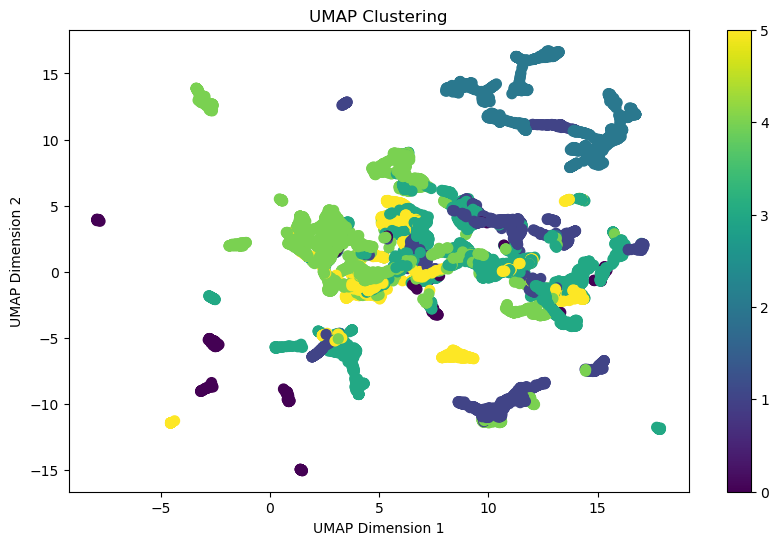

In [29]:

plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis', s=50)
plt.title('UMAP Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar()
plt.show()

In [17]:
# x1 = df['Nose_1_x']
# y1 = df['Nose_1_y']

# x0 = df['Nose_2_x']
# y0 = df['Nose_2_y']

# x = x1-x0
# y = y1-y0


# plt.figure(figsize=(10, 6))
# plt.scatter(x, y, c=labels, cmap='viridis', s=50)
# plt.title('Relative nose location')
# plt.xlabel('diff_x')
# plt.ylabel('diff_y')
# plt.colorbar()
# plt.show()

In [18]:
# # data_df = cluster_data[[c for c in cluster_data.columns if not 'derivative' in c]]
# data_df = cluster_data[distance_vars + distance_delta]
# data_df['labels'] = labels

# sns.pairplot(data_df, hue='labels', palette="bright")

In [19]:
# data_df = cluster_data[distance_vars + distance_delta]

# data_df['cluster_labels'] = cluster_labels

# sns.pairplot(data_df, hue='cluster_labels', palette="bright")

In [20]:
def smooth_time_series(arr, x, y):
    smoothed_arr = arr.copy()
    
    for i in range(len(arr)):
        start_idx = max(0, i - y + 1)
        end_idx = i + 1
        
        window = arr[start_idx:end_idx]
        
        if window.sum() < x:
            majority_class = np.bincount(window).argmax()
            smoothed_arr[i] = majority_class
    
    return smoothed_arr

cluster_labels_smoothed = smooth_time_series(cluster_labels, x=5, y=500)

In [21]:
# plt.hist(labels)

In [21]:
action_map

{2: 'subject_nose_poke_side',
 3: 'subject_sniff_tail',
 4: 'subject_sniff_nose',
 5: 'stimulus_sniff_subject_tail',
 6: 'mutual_sniff_of_tail',
 7: 'random_walk',
 8: 'both_are_moving_to_sniff',
 9: 'subject_head_scratch'}

In [27]:
labels_arr = np.full((1,10), 7)
labels_arr

array([[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]])

In [18]:
import cv2
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames

def generate_distinct_colors(num_groups, num_classes):
    # Calculate the base hue range for each group
    base_hues = np.linspace(0, 1, num_groups + 1)[:-1]

    # Calculate the class hue offset within each group
    class_hue_offsets = np.linspace(0, 1, num_classes + 1)[:-1] / (num_classes * 0.25)

    # Generate distinct RGB colors for each group and class
    colors = []
    for base_hue in base_hues:
        group_colors = []
        for hue_offset in class_hue_offsets:
            hue = (base_hue + hue_offset) % 1
            rgb_color = plt.cm.hsv(hue)
            group_colors.append(rgb_color[:3])  # Keep only RGB channels
        colors.append(group_colors)
    return colors

    
def draw_circles_with_text(frame, positions, colors, texts=None, text_color=(255, 255, 255),
                           radius=10, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=0.5, thickness=1):
    # Convert frame to RGB format (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    for ind, ((x, y), color) in enumerate(zip(positions, colors)):
        # Convert the color from 0-255 range to tuple format (BGR)
        b, g, r = color
        x = int(x)
        y = int(y)
        circle_color = (b*255, g*255, r*255)
        #print(circle_color)
        
        
        # Draw circle on the frame
        cv2.circle(frame_rgb, (x, y), radius, circle_color, -1)
        
        if texts is not None:
            text_pos = (x - radius, y - radius - 10)
            # Draw text on the frame
            text = texts[ind]
            
            frame_bgr = cv2.putText(frame_rgb, text, text_pos, font,
                        font_scale, text_color, thickness, lineType=cv2.LINE_AA)


          
    # Convert frame back to BGR format for display
    frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
    return frame_bgr
    

    
def display_label_on_video(frame, action_map, labels_array, diplay_map_flag=True, display_label_location=None ):
    height, width = frame.shape[:2]
    
    if display_label_location is None:
        display_label_location = (width//2, height//2 + 100)
    
    
    
def play_clustered_video(frames_in, cluster_labels, df_pose, columns_to_plot, additional_variables=None, show_class=None, enable_labeling=False):
    
    
    frame = frames_in[0].copy()
    height, width = frame.shape[:2]
    
    pos_1_x = df_pose[[a for a in columns_to_plot if '1' in a and '_x' in a]].values
    pos_1_y = df_pose[[a for a in columns_to_plot if '1' in a and '_y' in a]].values
    
    pos_2_x = df_pose[[a for a in columns_to_plot if '2' in a and '_x' in a]].values
    pos_2_y = df_pose[[a for a in columns_to_plot if '2' in a and '_y' in a]].values
    
    colnames_1_x =   [a for a in columns_to_plot if '1' in a and '_x' in a]
#     colnames_1_y =   [a for a in df_pos.columns if '1' in a and '_y' in a]
    
    colnames_2_x =   [a for a in columns_to_plot if '2' in a and '_x' in a]
#     colnames_2_y =   [a for a in df_pos.columns if '2' in a and '_y' in a]
    
    
    colors = generate_distinct_colors(2, len(colnames_1_x))

    
    frame_number = 0
    n_frames = len(frames)
    pause_vid = False
    
    pause_fliker_counter = 0
    fps = 29
    
    prev_key = -1
    continuous_presss = 1
    continuous_presss_factor = 1
    while frame_number < len(frames_in):
        
        
        key = cv2.waitKeyEx(int(1000 / fps))  # Display each frame for the appropriate time
        if key == prev_key and key !=-1:
            continuous_presss += 1
        else:
             continuous_presss = 1   
        continuous_presss_factor = 1+continuous_presss/fps*0.5
        prev_key = key
        
        if key == 27:  # Press 'Esc' to exit
            break
        elif key == 2424832: # Press 'Left Arrow' to go back 10 frames
            frame_number = np.max([0, frame_number-int(10*continuous_presss)])
        elif key == 2555904:
            frame_number = np.min([n_frames, frame_number+int(10*continuous_presss)-1]) # Press 'Right Arrow' to skip 10 frames
        elif key == 2490368 : # Predd "up" to speed up
            fps = np.min([100, fps+int(1*continuous_presss)])
        elif key == 2621440: # Predd "down" to slow down
            fps = np.max([1, fps-int(1*continuous_presss)])
        elif key == ord('r'): # Predd press "r" to reset
            fps = 29
        
        elif key == 32: # Pasue video
            pause_vid = not pause_vid
            pause_fliker_counter = 0
   

       
        if pause_vid:
            if key == 32:
                frame_temp = frame.copy()
                cv2.putText(frame_temp, f"Video Paused", (width//2, height//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 0, 255), 2)
            
            if pause_fliker_counter%50 <25:
                cv2.imshow("Clustered Video", frame_temp)
            else:
                cv2.imshow("Clustered Video", frame)
            pause_fliker_counter +=1
            continue
            
            
        frame_number = 0 if frame_number<0 else frame_number
        frame = frames_in[frame_number].copy()
        
        cluster = cluster_labels[frame_number]
        time = frame_number / fps
        
        if show_class is not None:
            while show_class != cluster and frame_number<n_frames:
                frame_number += 1
                cluster = cluster_labels[frame_number]
            
        if frame_number > n_frames:
            break      
        
        cv2.putText(frame, f"fps: {fps}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Frame: {frame_number}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Time: {time:.2f} s", (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
       
        cv2.putText(frame, f"Cluster: {cluster}", (width//2, height//2 + 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        if continuous_presss>1:
            cv2.putText(frame, f"Factor: {continuous_presss_factor}",
                        (20, 600), cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 0, 255), 2)
        if additional_variables:
            h = 160
            for var in additional_variables:
                value = np.round(df_pose.iloc[frame_number][var])
  
                cv2.putText(frame, f"{var}: {value:0.0f}", (20, h), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                h += 30
    
            
        x = pos_1_x[frame_number,:]
        y = pos_1_y[frame_number,:]
        pos_1 = list(zip(x,y))
        frame = draw_circles_with_text(frame, pos_1, colors[0], texts=colnames_1_x)
        
        x = pos_2_x[frame_number,:]
        y = pos_2_y[frame_number,:]
        pos_2 = list(zip(x,y))
        frame = draw_circles_with_text(frame, pos_2, colors[1], texts=colnames_2_x)
        
        
        cv2.imshow("Clustered Video", frame)
        
        frame_number+=1
        
        if cv2.getWindowProperty("Clustered Video", cv2.WND_PROP_VISIBLE) <1:
            break
    cv2.destroyAllWindows()
    


In [23]:
# # Manual rule based classification



# config = {
#     'sniff_dist_th':10
#     'sniff_dist_delta_th':1
#     'facing_margine': 45
# }

# # Invalid pose data
# # nose , left ear, right ear, 

# # subject is sniffing nose
# nose_to_nose_dist < config['sniff_dist_th'] and np.abs(nose_to_nose_dist_delta) < config['sniff_dist_delta_th']

# # subject iss sniffing tail
# nose1_to_tail2_dist < config['sniff_dist_th'] and np.abs(nose1_to_tail2_dist_delta) < config['sniff_dist_delta_th']

# # subject is going to sniff nose
# np.abs(nose_to_nose_dist_delta) > config['sniff_dist_delta_th']



In [31]:
# video_path = 'cropped_Rat1 probe 4-day2-free_2019-05-13-114301-0000.avi/'
video_path = df_full_path.replace('csv','avi')
if 'frames' not in globals():
    frames = load_video_frames(video_path)

In [35]:
frames

[array([[[187, 187, 187],
         [153, 153, 153],
         [183, 183, 183],
         ...,
         [ 12,  12,  12],
         [ 14,  14,  14],
         [ 16,  16,  16]],
 
        [[  3,   3,   3],
         [  0,   0,   0],
         [ 52,  52,  52],
         ...,
         [ 12,  12,  12],
         [ 14,  14,  14],
         [ 16,  16,  16]],
 
        [[ 11,  11,  11],
         [  0,   0,   0],
         [ 43,  43,  43],
         ...,
         [ 12,  12,  12],
         [ 14,  14,  14],
         [ 16,  16,  16]],
 
        ...,
 
        [[ 19,  19,  19],
         [ 20,  20,  20],
         [ 21,  21,  21],
         ...,
         [ 17,  17,  17],
         [ 15,  15,  15],
         [ 14,  14,  14]],
 
        [[ 17,  17,  17],
         [ 19,  19,  19],
         [ 21,  21,  21],
         ...,
         [ 17,  17,  17],
         [ 15,  15,  15],
         [ 14,  14,  14]],
 
        [[ 12,  12,  12],
         [ 14,  14,  14],
         [ 17,  17,  17],
         ...,
         [ 17,  17,  17],
  

In [30]:
labels = labels.reshape(-1)


In [33]:
# labels = smooth_time_series(labels, x=30, y=500)
joints_to_plot = [a for a in all_joints if '_derivative' not in a]

play_clustered_video(frames, labels, df_pose, columns_to_plot=joints_to_plot, additional_variables=columns_for_display, show_class=None)

In [ ]:
# labels = smooth_time_series(labels, x=30, y=500)
joints_to_plot = [a for a in all_joints if '_derivative' not in a]

play_clustered_video(frames, labels, df_pose, columns_to_plot=joints_to_plot, additional_variables=columns_for_display, show_class=None)